**Group 007-13 Project Proposal**

**Introduction**
The data set outlined below is the tennis data set. We kept specific columns in order to remove irrelevant data and keep the most important pieces of data to help us come to our research outcome. We will be investigating whether the number of rank points of a winner or loser of a professional tennis match can be predicted. We will evaluate their overall ranking by comparing players rank points with their height, their break points, and their double faults. Break points are considered when the receiving player can win the game by scoring the next point. Double faults are when a player makes two mistakes during their serve. Break points, height, and double faults can be looked at and related to rank points in order to find the correlation to a tennis player's overall ranking.

**Preliminary exploratory data analysis**
*In code cells below, demonstrate that data can be read into R and then follow the instructions on Canvas*

In [2]:
#loading data and libraries
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

download.file("https://drive.google.com/uc?export=download&id=1fOQ8sy_qMkQiQEAO6uFdRX4tLI8EpSTn", "tennis_data.csv")
tennis_data <- read_csv("tennis_data.csv", show_col_types = FALSE)
#tennis_data

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

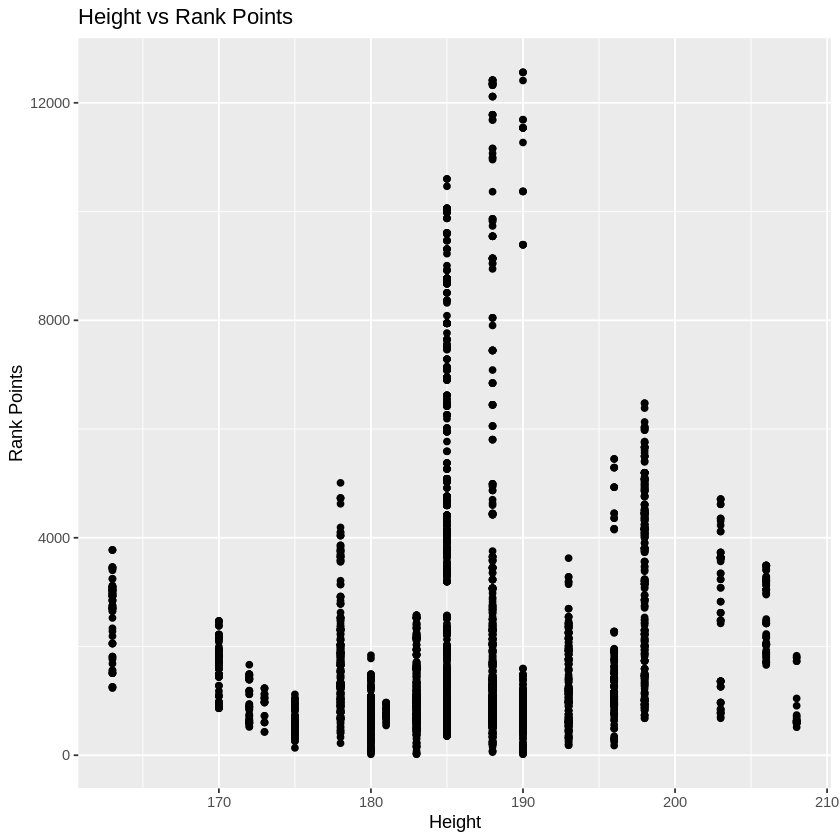

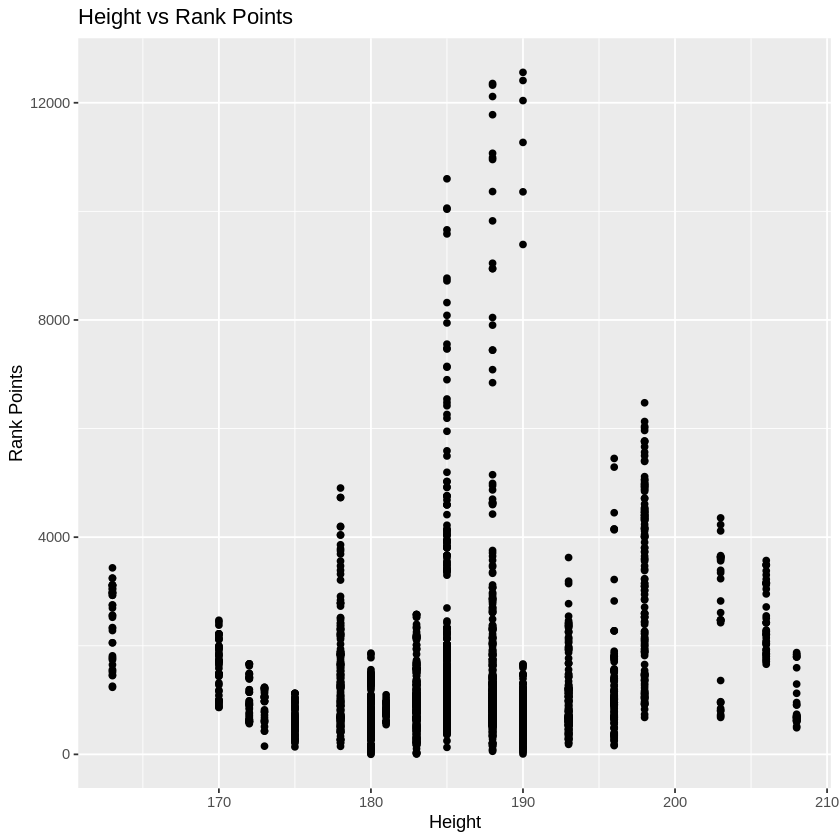

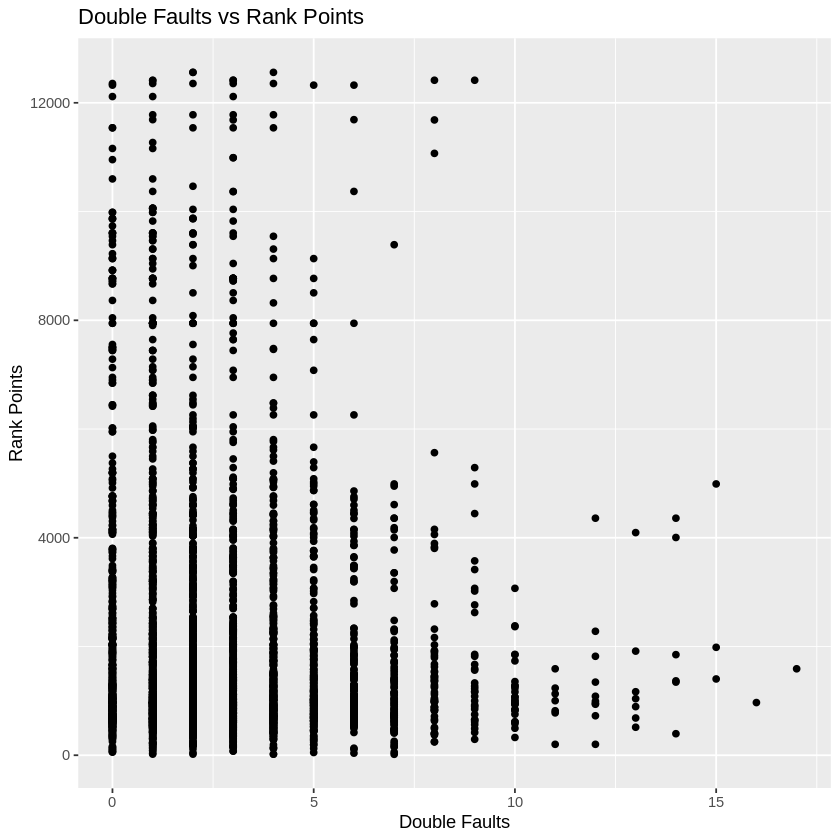

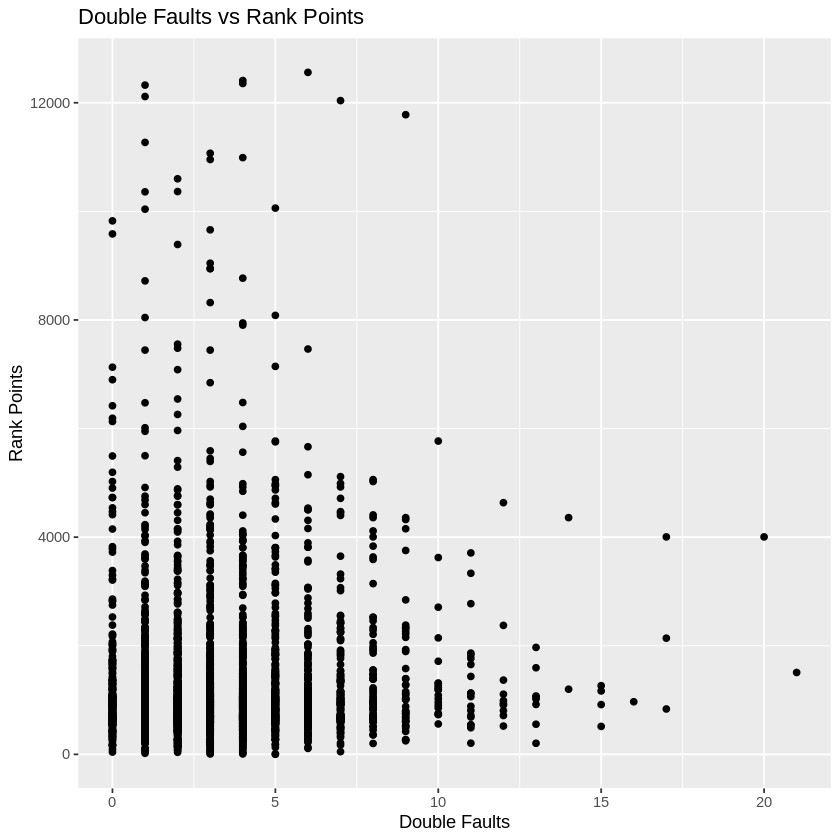

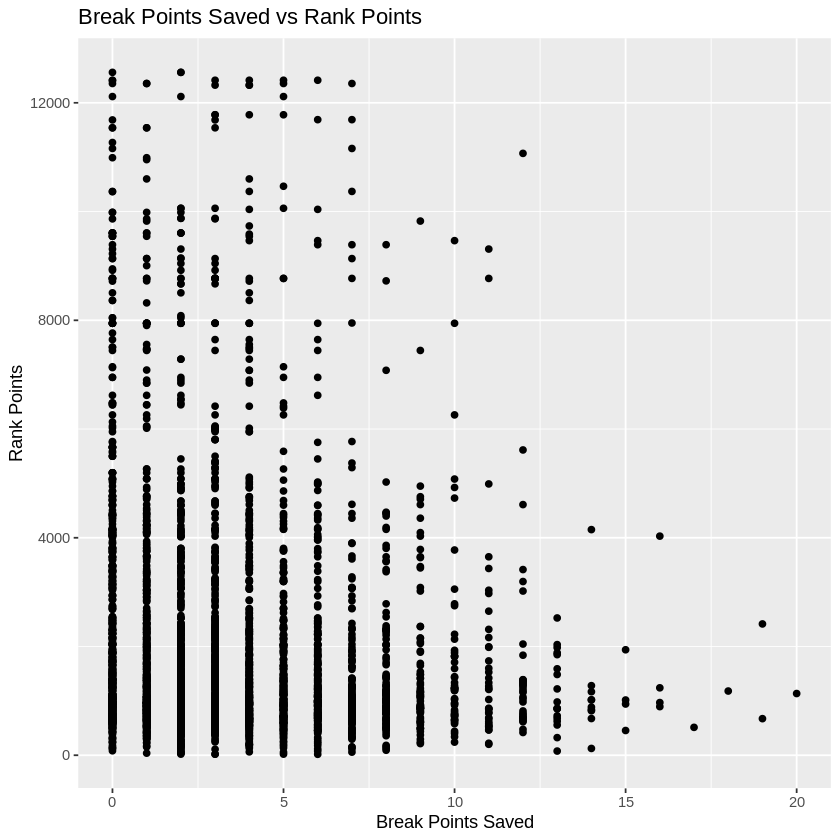

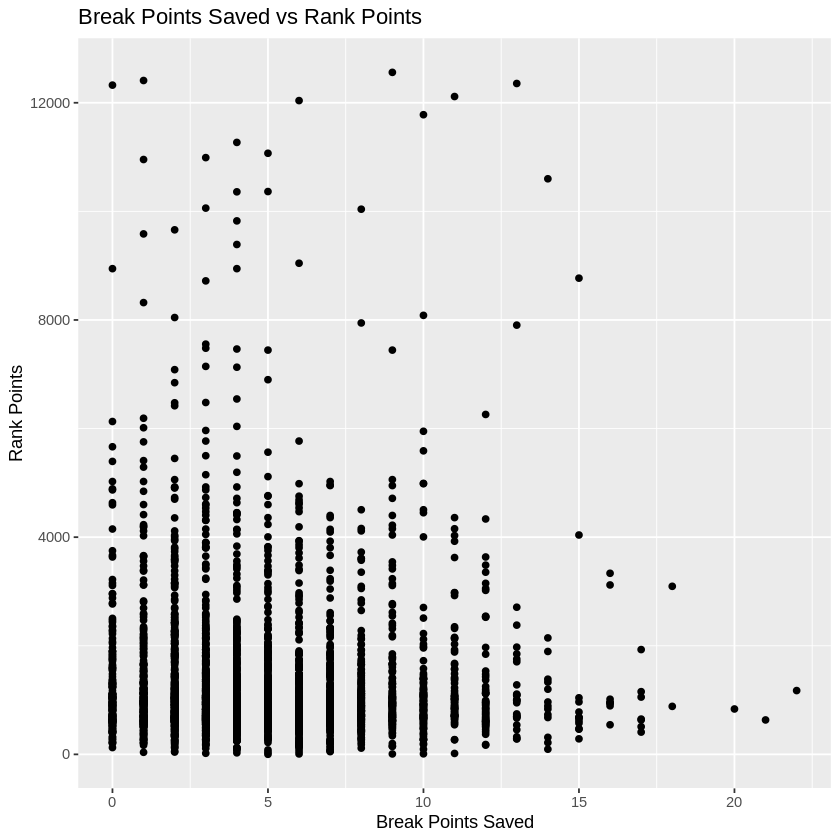

In [19]:
#prepping data
set.seed(2132)

winner_data <- tennis_data |> select(winner_rank_points, winner_ht, w_df, w_bpSaved) |> na.omit()
loser_data <-  tennis_data |> select(loser_rank_points, loser_ht, l_df, l_bpSaved) |> na.omit()

winner_split <- initial_split(winner_data, prop = .75, strata = winner_rank_points)  
winner_train <- training(winner_split)
winner_test <- testing(winner_split)
# winner_train

loser_split <- initial_split(loser_data, prop = .75, strata = loser_rank_points)  
loser_train <- training(loser_split)
loser_test <- testing(loser_split)
# loser_train

win_height_plot <- ggplot(winner_train, aes(x = winner_ht, y = winner_rank_points)) +
    geom_point() +
    labs(title = "Height vs Rank Points", x = "Height", y = "Rank Points")
win_height_plot

lose_height_plot <- ggplot(loser_train, aes(x = loser_ht, y = loser_rank_points)) +
    geom_point() +
    labs(title = "Height vs Rank Points", x = "Height", y = "Rank Points")
lose_height_plot

win_df_plot <- ggplot(winner_train, aes(x = w_df, y = winner_rank_points)) +
    geom_point() +
    labs(title = "Double Faults vs Rank Points", x = "Double Faults", y = "Rank Points")
win_df_plot

lose_df_plot <- ggplot(loser_train, aes(x = l_df, y = loser_rank_points)) +
    geom_point() +
    labs(title = "Double Faults vs Rank Points", x = "Double Faults", y = "Rank Points")
lose_df_plot

win_bpSaved_plot <- ggplot(winner_train, aes(x = w_bpSaved, y = winner_rank_points)) +
    geom_point() +
    labs(title = "Break Points Saved vs Rank Points", x = "Break Points Saved", y = "Rank Points")
win_bpSaved_plot

lose_bpSaved_plot <- ggplot(loser_train, aes(x = l_bpSaved, y = loser_rank_points)) +
    geom_point() +
    labs(title = "Break Points Saved vs Rank Points", x = "Break Points Saved", y = "Rank Points")
lose_bpSaved_plot

**Methods**
*Explain how you will conduct either your data analysis and which variables/columns you will use.
Describe at least one way that you will visualize the results*

**Expected outcomes and significance** *Answer questions on Canvas*